<a href="https://colab.research.google.com/github/Divyanshiii-23/SURGE-2025/blob/main/CNN_AMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.5 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras import activations
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import matthews_corrcoef,auc, roc_curve,classification_report, confusion_matrix,average_precision_score, precision_recall_curve
from keras.layers import Dense,Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.layers import BatchNormalization

In [ ]:
############################# Step2: load metrics function #####################
### F1 score, precision, recall and accuracy metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
############################# Step3: input data processing #####################
data = pd.read_csv("/content/cip_ctx_ctz_gen_multi_data.csv",index_col=0)
pheno = pd.read_csv("/content/cip_ctx_ctz_gen_pheno.csv",index_col=0)
data.shape,pheno.shape
# Make sure sample IDs are aligned
common_ids = data.index.intersection(pheno.index)
data2 = data.loc[common_ids]
pheno2 = pheno.loc[common_ids]["CIP"].values.reshape(-1,)

# Use the correct phenotype column (e.g., "CIP")
pheno2 = pheno["CIP"].values.reshape(-1,)
data2 = data.values
#pheno2 = pheno.values.reshape(pheno.shape[0],)
pheno2 = pheno["CIP"].values.reshape(-1,)
data2.shape,pheno2.shape
X_train, X_test, y_train, y_test = train_test_split(data2, pheno2, test_size= 0.20, stratify= pheno2, random_state= 123)
X_train.shape,X_test.shape,y_train.shape,y_test.shape


inputs = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
inputs = inputs.astype('float32')
targets = to_categorical(y_train)
inputs.shape,targets.shape

X_test2 = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
X_test2 = X_test2.astype('float32')
y_test2 = to_categorical(y_test)
X_test2.shape,y_test2.shape

((162, 60936, 1), (162, 2))

In [ ]:
# Align by sample name
data = data.loc[data.index.intersection(pheno.index)]
pheno = pheno.loc[data.index]


In [ ]:
############################# Step4: model training #####################
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
batch_size = 8
no_classes = 2
no_epochs = 50
verbosity = 1
num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)
# K-fold Cross Validation model evaluation
fold_no = 1
model_history=[]
for train, test in kfold.split(inputs, targets):
 model = Sequential()
 model.add(Conv1D(filters=8, kernel_size=3,activation='relu', input_shape=(inputs.shape[1], 1)))
 model.add(BatchNormalization())
 model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
 #model.add(BatchNormalization())
 model.add(MaxPooling1D(pool_size=(2)))
 model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
 model.add(BatchNormalization())
 model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
 #model.add(BatchNormalization())
 model.add(MaxPooling1D(pool_size=(2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu'))
 model.add(Dropout(0.2))
 model.add(Dense(2,activation='softmax'))
 # Compile the model
 model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',f1_m,precision_m, recall_m])
 # Generate a print
 print('--------------------------------')
 print(f'Training for fold {fold_no} ...')
 ## checkpoint for saving model
 filepath="Train_CNN_weights.best.keras"
 checkpoint = ModelCheckpoint(filepath, monitor='val_f1_m', verbose=1, save_best_only=True,mode='max')
 early_stop = EarlyStopping(monitor='val_f1_m', patience=10, restore_best_weights=True, mode='max')
 callbacks_list = [checkpoint, early_stop]

 # Fit data to model
 train_model = model.fit(inputs[train],targets[train],batch_size=batch_size,epochs=no_epochs,callbacks=callbacks_list,verbose=verbosity,validation_data=(inputs[test],targets[test]))
 model_history.append(train_model.history)
 # Increase fold number
 fold_no = fold_no + 1

########## (2) save model
#model.save_weights('CNN.model.h5')

# save model history
from pandas.core.frame import DataFrame
# Convert list of history dicts to list of DataFrames, each with a 'fold' column
history_dfs = []
for i, history in enumerate(model_history):
    df = pd.DataFrame(history)
    df['fold'] = i + 1
    history_dfs.append(df)

# Concatenate all folds
model_out = pd.concat(history_dfs, ignore_index=True)
model_out.to_csv("Train_CNN_model_history_out.csv",index=False)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--------------------------------
Training for fold 1 ...
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - acc: 0.5576 - f1_m: 0.5577 - loss: 70.1524 - precision_m: 0.5577 - recall_m: 0.5577
Epoch 1: val_f1_m improved from -inf to 0.48529, saving model to Train_CNN_weights.best.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - acc: 0.5581 - f1_m: 0.5582 - loss: 69.6378 - precision_m: 0.5582 - recall_m: 0.5582 - val_acc: 0.4846 - val_f1_m: 0.4853 - val_loss: 0.7682 - val_precision_m: 0.4853 - val_recall_m: 0.4853
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - acc: 0.7679 - f1_m: 0.7679 - loss: 2.7920 - precision_m: 0.7679 - recall_m: 0.7679
Epoch 2: val_f1_m improved from 0.48529 to 0.77941, saving model to Train_CNN_weights.best.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - acc: 0.7681 - f1_m: 0.7682 - loss: 2.7798 - precision_m: 0.7682 - recall_m: 0.7682 - val_acc: 0.7923 - val_f1_m: 0.7794 - val_loss: 0.6000 - val_precision_m: 0.7794 - val_recall_m: 0.7794
Epoch 3/50
65/65 ━

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step


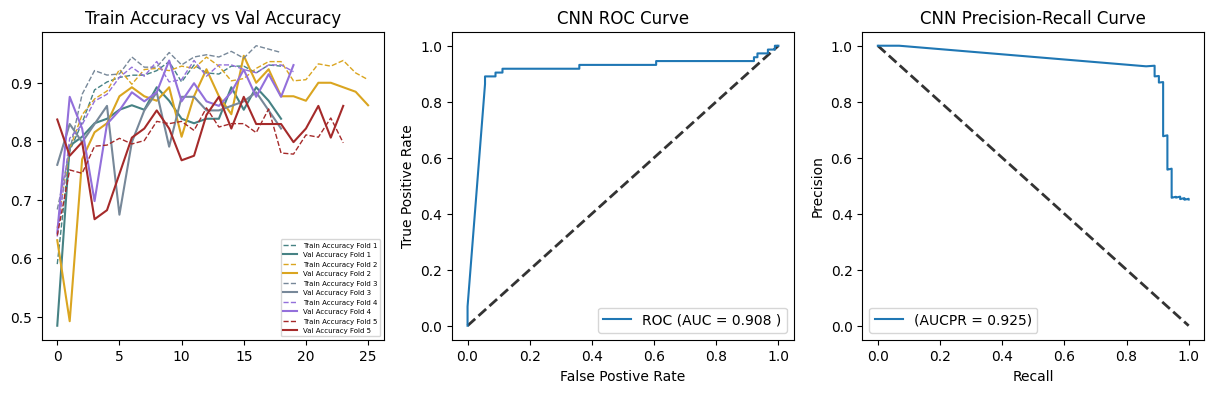

In [ ]:
############################# Step5: Evaluation #####################
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
import numpy as np

# Convert one-hot encoded y_test and softmax y_pred to class labels
y_pred_cls = np.argmax(y_pred, axis=1)

# Write metrics to file
with open("Test_CNN_MCC_metrics.csv", "w") as f:
    print(confusion_matrix(y_test, y_pred_cls), file=f)
    print(classification_report(y_test, y_pred_cls), file=f)
    print(matthews_corrcoef(y_test, y_pred_cls), file=f)


############################# Plot accuracy #####################
import matplotlib.pyplot as plt
fig,[ax10,ax11,ax12] = plt.subplots(nrows=1,ncols=3,figsize=(15, 4))
ax10.plot(model_history[0]['acc'], linestyle='--',lw=1,color='#468284',label='Train Accuracy Fold 1')
ax10.plot(model_history[0]['val_acc'], color='#468284',label='Val Accuracy Fold 1')
ax10.plot(model_history[1]['acc'], linestyle='--',lw=1,color='#DAA520',label='Train Accuracy Fold 2' )
ax10.plot(model_history[1]['val_acc'], color='#DAA520',label='Val Accuracy Fold 2')
ax10.plot(model_history[2]['acc'], linestyle='--',lw=1,color='#778899',label='Train Accuracy Fold 3' )
ax10.plot(model_history[2]['val_acc'], color='#778899',label='Val Accuracy Fold 3')
ax10.plot(model_history[3]['acc'], linestyle='--',lw=1,color='#9370DB',label='Train Accuracy Fold 4',)
ax10.plot(model_history[3]['val_acc'], color='#9370DB',label='Val Accuracy Fold 4')
ax10.plot(model_history[4]['acc'], linestyle='--',lw=1,color='#A52A2A',label='Train Accuracy Fold 5' )
ax10.plot(model_history[4]['val_acc'], color='#A52A2A',label='Val Accuracy Fold 5')
ax10.set(title='Train Accuracy vs Val Accuracy')
ax10.legend(prop={'size':5})
#plt.savefig('Train_CNN_acc_eva.pdf')

##### plot ROC curve and PR curve
### ROC
y_pred_keras = model.predict(X_test2)
fpr_keras, tpr_keras,thresholds_keras = roc_curve(y_test,y_pred_keras[:,1])
auc_keras = auc(fpr_keras,tpr_keras)
ax11.plot([0,1],[0,1],linestyle="--",lw=2,color='k',alpha=.8)
ax11.plot(fpr_keras,tpr_keras,label= 'ROC (AUC = {:.3f} )'.format(auc_keras))
ax11.set(xlabel='False Postive Rate',ylabel='True Positive Rate',title="CNN ROC Curve")
ax11.legend(loc='lower right')
#plt.savefig("Test_CNN_ROC_curve.pdf",bbox_inches='tight')

###### PR curve
probas = model.predict(X_test2)
precision,recall,thresholds = precision_recall_curve(y_test,probas[:,1])
pr_auc = auc(recall,precision)
ax12.plot([0,1],[1,0],linestyle="--",lw=2,color='k',alpha=.8)
ax12.plot(recall,precision,label= '(AUCPR = {:.3f})'.format(pr_auc))
ax12.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],xlabel='Recall',ylabel='Precision',title="CNN Precision-Recall Curve")
ax12.legend(loc='lower left')
plt.savefig("CNN_Acc_ROC_P-R_curve.pdf")

### MCC
y_pred=model.predict(X_test2)
y_pred_cls= np.argmax(y_pred, axis=1)
f=open("Test_CNN_MCC_metrics.csv","w")
print(confusion_matrix(y_test, y_pred_cls), file=f)
print(classification_report(y_test, y_pred_cls), file=f)
print(matthews_corrcoef(y_test, y_pred_cls), file=f)

f.close()